In [9]:
import os
from os.path import join
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from scipy.stats import sem
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(color_codes=True, style="white")
pd.options.mode.chained_assignment = None  # default='warn'

# Displacement threshold for immobile molecules
immobile_stepsize_threshold_nm = 30
# alpha component threshold for constrained diffusion
threshold_alpha = 0.7

label_1 = "mRNA\nN=79,202"
label_2 = "FUS\nN=232,090"
color_1 = "#9a3324"
color_2 = "#00274c"
color_3 = "#333232"
palette = [color_1, color_2, color_3]

postfix = "FL_FUS_in_FL_out_3in1.png"

folder_data = "/Volumes/lsa-nwalter/Guoming_Gao_turbo/Walterlab_server/PROCESSED_DATA/RNA-diffusion-in-FUS/paper_figure_plots/bioRxiv_version_Figs/Fig2/FL_FUS_in_FL_out_3in1"
folder_save = "/Volumes/lsa-nwalter/Guoming_Gao_turbo/Walterlab_server/PROCESSED_DATA/RNA-diffusion-in-FUS/paper_figure_plots/revision1"
fname_AIO_1 = "SPT_results_AIO_concat-0Dex_noTR_0hr.csv"
fname_AIO_2 = "SPT_results_AIO_concat-20ms_FUS488_incondensate_4Reps.csv"

## Combine dataframes

In [10]:
os.chdir(folder_save)

df1 = pd.read_csv(join(folder_data, fname_AIO_1))
df2 = pd.read_csv(join(folder_data, fname_AIO_2))
print(label_1, df1.shape[0])
print(label_2, df2.shape[0])

mRNA
N=79,202 79202
FUS
N=232,090 232090


In [11]:
df1.insert(0, "label", np.repeat(label_1, df1.shape[0]))
df2.insert(0, "label", np.repeat(label_2, df2.shape[0]))

# Below sequence is important for the layer order
df_AIO = pd.concat([df1, df2], ignore_index=True)

## Track Length Distribution

/var/folders/4j/rqqtl9616j1197zqmj5bs04r0000gn/T/ipykernel_30987/1207149982.py:7: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  ax = sns.histplot(


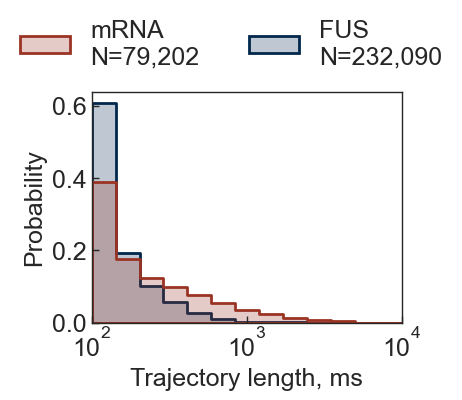

In [34]:
# data = df_AIO[df_AIO["mean_stepsize_nm"] > immobile_stepsize_threshold_nm]
# data = data[data["linear_fit_R2"] > 0.7]
data = df_AIO
data["tracklength"] = data["N_steps"] * 20
# quantile = np.quantile(df_AIO["linear_fit_sigma"].dropna().to_numpy(), 0.999)
plt.figure(figsize=(4, 3))
ax = sns.histplot(
    data=data,
    x="tracklength",
    hue="label",
    palette=palette,
    bins=15,
    # binrange=(60, 5000),
    stat="probability",
    common_norm=False,
    lw=2,
    element="step",
    log_scale=True,
)
plt.xlim(100, 1e4)

sns.move_legend(
    ax,
    "lower center",
    bbox_to_anchor=(0.45, 1),
    ncol=3,
    title=None,
    frameon=False,
    fontsize=18,
)
plt.xlabel("Trajectory length, ms", fontsize=18)
plt.ylabel("Probability", fontsize=18)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=18,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=1,
)
plt.gca().set_axisbelow(False)
plt.gca().tick_params(axis="both", which="major", labelsize=18)
plt.savefig("Tracklength.png", format="png", bbox_inches="tight", dpi=300)

## N per condensate

In [53]:
folder_PAINT = "/Volumes/lsa-nwalter/Guoming_Gao_turbo/Walterlab_server/PROCESSED_DATA/RNA-diffusion-in-FUS/paper_figure_plots/bioRxiv_version_Figs/Fig3/FUS488_FL_PAINT/pooled_better_best"
fpaths_FUS = [f for f in os.listdir(folder_PAINT) if f.endswith("left.csv")]
fpaths_RNA = [f for f in os.listdir(folder_PAINT) if f.endswith("right.csv")]

In [55]:
df = pd.read_csv(join(folder_PAINT, fpaths_RNA[0]))
df.keys()

Index(['spotID', 'trackID', 'QUALITY', 'x', 'y', 't', 'R', 'meanIntensity',
       'medianIntensity', 'minIntensity', 'maxIntensity', 'totalIntensity',
       'stdIntensity', 'contrast', 'SNR'],
      dtype='object')

In [67]:
def count_Ntrack(df):
    count = df["trackID"].unique().shape[0]
    return count


def calculate_R(df_FUS, df_RNA):
    maxR = (
        np.max([np.ptp(df_FUS.x), np.ptp(df_FUS.y), np.ptp(df_RNA.x), np.ptp(df_RNA.y)])
        * 0.117
        / 2
    )
    return maxR  # unit: um


lst_Ntrack_FUS = []
lst_Ntrack_RNA = []
lst_condensate_R = []
for path_FUS, path_RNA in zip(fpaths_FUS, fpaths_RNA):
    df_FUS = pd.read_csv(join(folder_PAINT, path_FUS))
    df_RNA = pd.read_csv(join(folder_PAINT, path_RNA))
    lst_Ntrack_FUS.append(count_Ntrack(df_FUS))
    lst_Ntrack_RNA.append(count_Ntrack(df_RNA))
    lst_condensate_R.append(calculate_R(df_FUS, df_RNA))

In [79]:
N_condensate = len(lst_condensate_R)
data = pd.DataFrame(
    {
        "Ntrack": lst_Ntrack_FUS + lst_Ntrack_RNA,
        "condensate_R": lst_condensate_R + lst_condensate_R,
        "label": np.concatenate(
            [np.repeat("FUS", N_condensate), np.repeat("RNA", N_condensate)]
        ),
    }
)

/var/folders/4j/rqqtl9616j1197zqmj5bs04r0000gn/T/ipykernel_30987/2398048479.py:2: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  ax = sns.histplot(


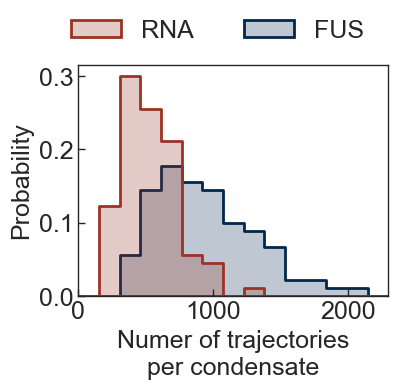

In [92]:
plt.figure(figsize=(4, 3))
ax = sns.histplot(
    data=data,
    x="Ntrack",
    hue="label",
    palette=palette,
    hue_order=["RNA", "FUS"],
    bins=15,
    binrange=(0, 2.3e3),
    stat="probability",
    common_norm=False,
    lw=2,
    element="step",
    # log_scale=True,
)
plt.xlim(0, 2.3e3)

sns.move_legend(
    ax,
    "lower center",
    bbox_to_anchor=(0.45, 1),
    ncol=2,
    title=None,
    frameon=False,
    fontsize=18,
)
plt.xlabel("Numer of trajectories\nper condensate", fontsize=18)
plt.ylabel("Probability", fontsize=18)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=18,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=1,
)
plt.gca().set_axisbelow(False)
plt.gca().tick_params(axis="both", which="major", labelsize=18)
plt.savefig("Ntrack_distribution.png", format="png", bbox_inches="tight", dpi=300)

/Users/GGM/anaconda3/envs/spt/lib/python3.9/site-packages/seaborn/axisgrid.py:1826: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  func(x=self.x, y=self.y, **kwargs)
/Users/GGM/anaconda3/envs/spt/lib/python3.9/site-packages/seaborn/axisgrid.py:1877: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)
/Users/GGM/anaconda3/envs/spt/lib/python3.9/site-packages/seaborn/axisgrid.py:1883: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  func(y=self.y, ax=self.ax_marg_y, **kwargs)


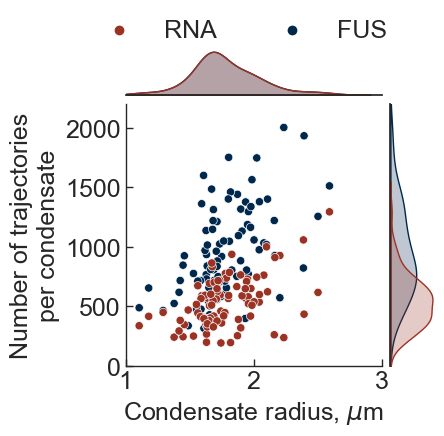

In [93]:
# Remove the plt.figure() call since jointplot creates its own figure
g = sns.jointplot(
    data=data,
    x="condensate_R",
    y="Ntrack",
    hue="label",
    hue_order=["RNA", "FUS"],
    palette=palette,
    height=4,  # equivalent to figsize=(4, 4)
)

# Set axis limits
g.ax_joint.set_xlim(1, 3)
g.ax_joint.set_ylim(0, 2200)

# Also set limits on marginal plots to keep them consistent
g.ax_marg_x.set_xlim(1, 3)
g.ax_marg_y.set_ylim(0, 2200)

# Move legend using the JointGrid object
sns.move_legend(
    g.ax_joint,  # Use the main plot axes from the JointGrid
    "lower center",
    ncol=2,
    bbox_to_anchor=(0.45, 1.15),
    title=None,
    frameon=False,
    fontsize=18,
)

# Set labels and formatting on the main plot axes
g.ax_joint.set_xlabel(r"Condensate radius, $\mu$m", fontsize=18)
g.ax_joint.set_ylabel("Number of trajectories\nper condensate", fontsize=18)

# Apply formatting to the main plot axes
for spine in g.ax_joint.spines.values():
    spine.set_linewidth(1)

g.ax_joint.tick_params(
    axis="both",
    which="major",
    labelsize=18,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=1,
)
g.ax_joint.set_axisbelow(False)

plt.savefig(
    "Ntrack_condensate_R_relationship.png", format="png", bbox_inches="tight", dpi=300
)